In [294]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_union, make_pipeline, FeatureUnion, Pipeline
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer, MinMaxScaler, \
    Normalizer
from sklearn.decomposition import TruncatedSVD
import timeit

%matplotlib inline

In [338]:
df = pd.read_csv('datasets/bgg_db_2017_04.csv',encoding='cp1250')

In [267]:
df.head() 

,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66905,8.48904,18009,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",29472,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8076
1,2,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.72977,8.30744,7309,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",10007,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3093
2,3,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,180,180,2005,8.35745,8.22021,27403,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",37382,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5317
3,4,https://boardgamegeek.com/boardgame/120677/ter...,120677,Terra Mystica,2,5,150,60,150,2012,8.29627,8.15458,24267,https://cf.geekdo-images.com/images/pic1356616...,12,"Route/Network Building, Variable Phase Order, ...",27948,"Civilization, Economic, Fantasy, Territory Bui...","Jens Drögemüller, Helge Ostertag",3.9387
4,5,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.08970,8.15151,3978,https://cf.geekdo-images.com/images/pic2437871...,12,"Action / Movement Programming, Campaign / Batt...",6057,"Adventure, Economic, Exploration, Fantasy, Fig...",Isaac Childres,3.7028


In [268]:
#drop columns that only contain unique values for each game
df.drop(['bgg_url','game_id','image_url'],axis=1,inplace=True)
#drop rank as it's just a proxy for geek_rating
df.drop('rank',axis=1,inplace=True)
df.head(3)

,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,mechanic,owned,category,designer,weight
0,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66905,8.48904,18009,13,"Action Point Allowance System, Co-operative Pl...",29472,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8076
1,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.72977,8.30744,7309,14,"Action Point Allowance System, Auction/Bidding...",10007,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3093
2,Twilight Struggle,2,2,180,180,180,2005,8.35745,8.22021,27403,13,"Area Control / Area Influence, Campaign / Batt...",37382,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5317


In [269]:
df.shape

(4999, 16)

In [270]:
df.isnull().sum()

names          0
min_players    0
max_players    0
avg_time       0
min_time       0
max_time       0
year           0
avg_rating     0
geek_rating    0
num_votes      0
age            0
mechanic       0
owned          0
category       0
designer       0
weight         0
dtype: int64

In [271]:
df['name_len'] = df.names.map(lambda x: len(x))

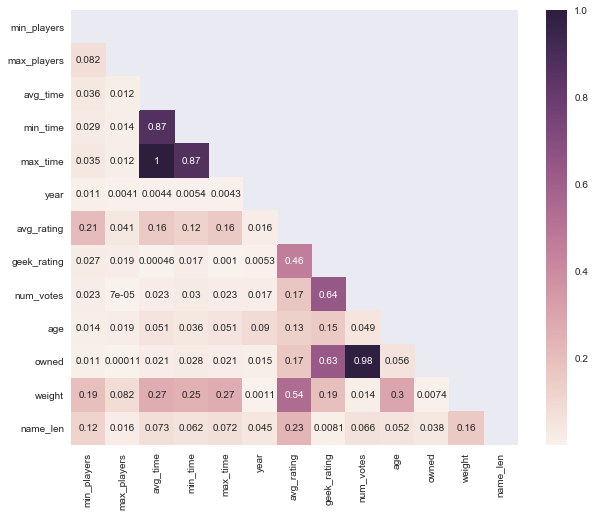

In [272]:
corr = df.corr().abs()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8))
sns.heatmap(corr,mask=mask,annot=True)

In [273]:
#drop highly colinear features
df.drop(['min_time','max_time','owned'],axis=1,inplace=True)

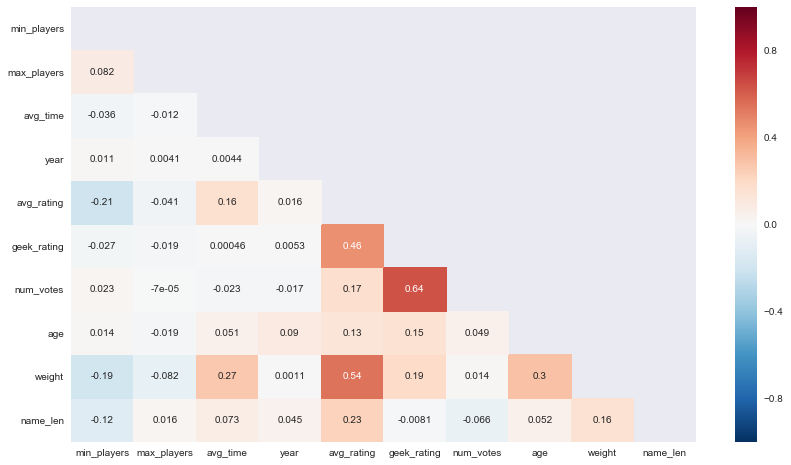

In [274]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14,8))
sns.heatmap(corr,mask=mask,annot=True)

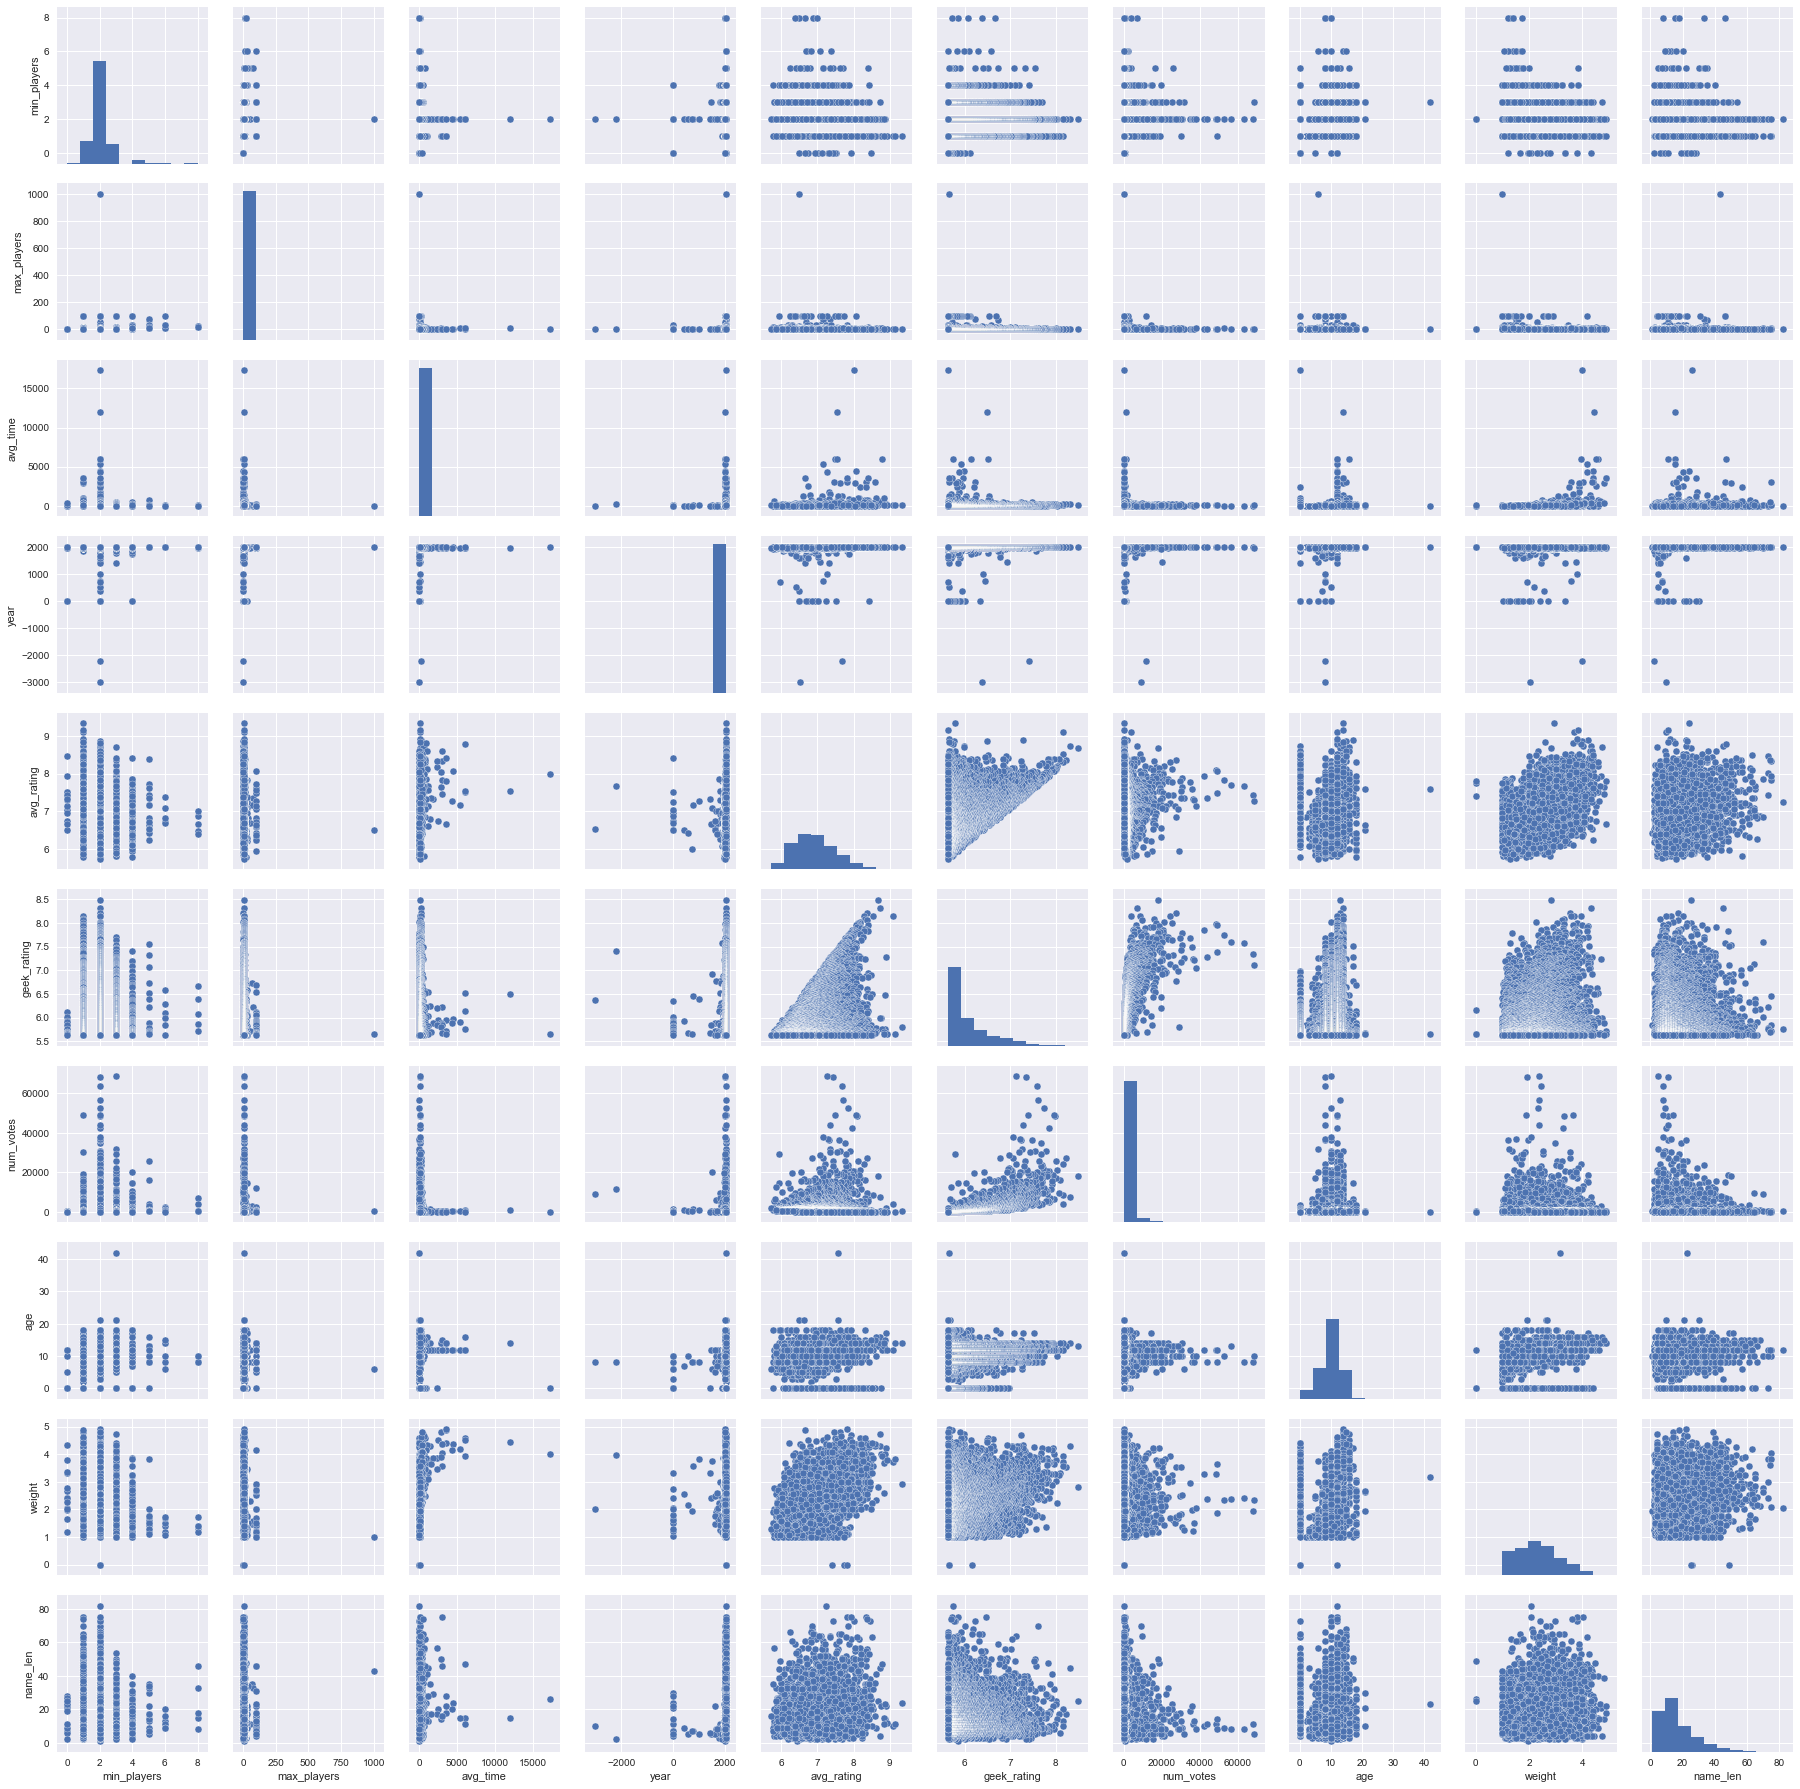

In [275]:
sns.pairplot(df)

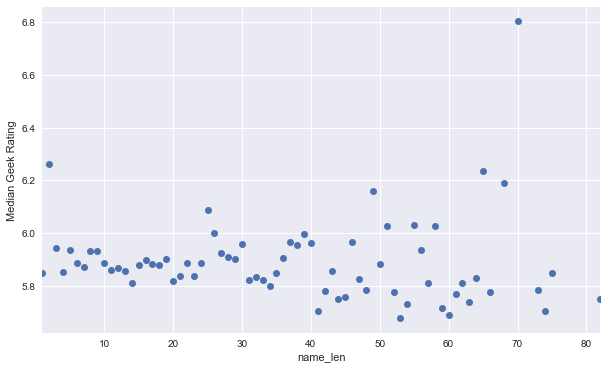

In [276]:
df.groupby('name_len').median()['geek_rating'].plot(figsize=(10,6),marker='o',linestyle='none')
plt.ylabel('Median Geek Rating')

In [277]:
df.groupby('name_len').count()['names'].values

array([  1,  10,  36, 100, 160, 241, 243, 292, 296, 305, 270, 235, 254,
       227, 203, 157, 153, 142, 144, 128,  90,  94, 107,  82,  80,  64,
        84,  66,  65,  57,  53,  47,  52,  39,  42,  41,  34,  30,  25,
        30,  13,  18,  19,  14,  13,  14,  15,  11,  17,   9,   8,   6,
         3,   4,   5,   6,   5,   1,   4,   1,   4,   5,   5,   3,   4,
         2,   1,   2,   3,   1,   3,   1], dtype=int64)

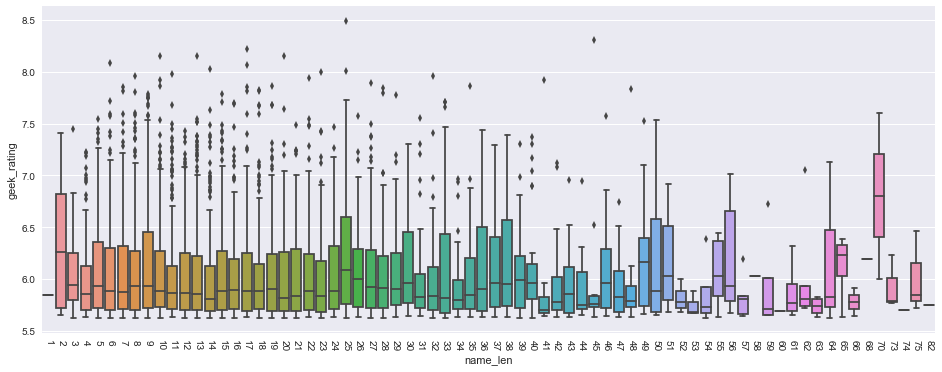

In [278]:
plt.figure(figsize=(16,6))
sns.boxplot('name_len','geek_rating',data=df)#,color=df.groupby('name_len').count()['names'].values)
plt.xticks(rotation=270)
# plt.colorbar()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000207C8A626D8>]], dtype=object)

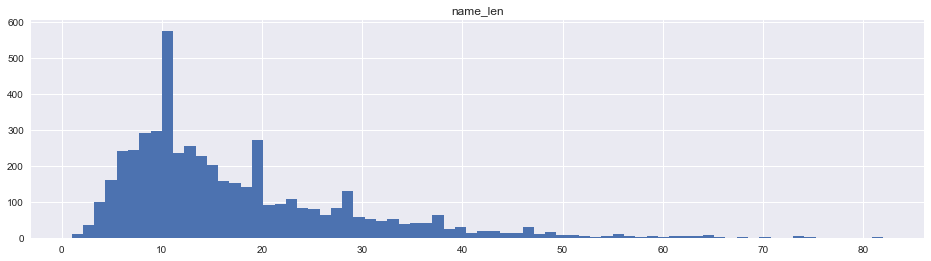

In [279]:
df.hist('name_len',bins=72,figsize=(16,4),)

(0, 1000)

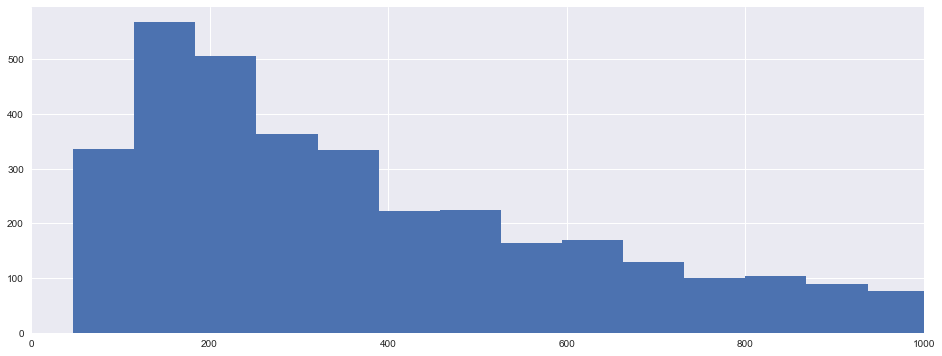

In [315]:
df['num_votes'].hist(bins=1000,figsize=(16,6))
plt.xlim(0,1000)

In [280]:
df.head()

,names,min_players,max_players,avg_time,year,avg_rating,geek_rating,num_votes,age,mechanic,category,designer,weight,name_len
0,Pandemic Legacy: Season 1,2,4,60,2015,8.66905,8.48904,18009,13,"Action Point Allowance System, Co-operative Pl...","Environmental, Medical","Rob Daviau, Matt Leacock",2.8076,25
1,Through the Ages: A New Story of Civilization,2,4,240,2015,8.72977,8.30744,7309,14,"Action Point Allowance System, Auction/Bidding...","Card Game, Civilization, Economic",Vlaada Chvátil,4.3093,45
2,Twilight Struggle,2,2,180,2005,8.35745,8.22021,27403,13,"Area Control / Area Influence, Campaign / Batt...","Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5317,17
3,Terra Mystica,2,5,150,2012,8.29627,8.15458,24267,12,"Route/Network Building, Variable Phase Order, ...","Civilization, Economic, Fantasy, Territory Bui...","Jens Drögemüller, Helge Ostertag",3.9387,13
4,Gloomhaven,1,4,150,2017,9.08970,8.15151,3978,12,"Action / Movement Programming, Campaign / Batt...","Adventure, Economic, Exploration, Fantasy, Fig...",Isaac Childres,3.7028,10


In [320]:
df.num_votes.std(),df.num_votes.mean()

(4094.167154075361, 1698.1502300460093)

In [281]:
X = df.drop('geek_rating',axis=1)
y = df.geek_rating
X_use, X_hold, y_use, y_hold = train_test_split(X,y,test_size=.25)
X_train, X_test, y_train, y_test = train_test_split(X_use,y_use,test_size=.25)

In [282]:
def cleaning(text):
    text = text.split(',')
    text = [word.strip() for word in text]
    return text
cvec = CountVectorizer(analyzer=cleaning)
mech_dummies = pd.DataFrame(cvec.fit_transform(X_train.mechanic).todense(),columns=cvec.get_feature_names())
mech_dummies.head()

,Acting,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,...,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,none
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [370]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Select out one or more features and returns them in the shape (n_rows,n_features)"""
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if type(self.column) == list:
            return X[self.column].values 
        else:
            return X[[self.column]].values 
        

class RowFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select out one feature and return it in the shape (n_rows,)"""
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.column].values 

def str_len(x):
    return np.array([len(name) for name in x]).reshape(-1,1)

mechanic_pipe = make_pipeline(
    RowFeatureExtractor('mechanic'),
    CountVectorizer(analyzer=cleaning)
)

category_pipe = make_pipeline(
    RowFeatureExtractor('category'),
    CountVectorizer(analyzer=cleaning)
)

designer_pipe = make_pipeline(
    RowFeatureExtractor('designer'),
    CountVectorizer(analyzer=cleaning)
)

#sigma clipping, minmaxscaling
def sigma_clip(df):
    df = pd.DataFrame(df,columns=['name_len','min_players','max_players','avg_time',
                      'year','avg_rating','num_votes','age','weight'])
    n_low = 3
    n_high = 3
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        df.loc[df[col]<mean-n_low*std,col] = mean - n_low*std
        df.loc[df[col]>mean+n_high*std,col] = mean + n_high*std
    return df.values
SigmaClipTF = FunctionTransformer(sigma_clip)

numerical_pipe = make_pipeline(
    FeatureExtractor(['name_len','min_players','max_players','avg_time',
                      'year','avg_rating','num_votes','age','weight']),
    SigmaClipTF,
    MinMaxScaler()
)

fu = make_union(
    numerical_pipe,
    mechanic_pipe,
    category_pipe,
    designer_pipe
)

In [371]:
pipe = Pipeline([
    ('fu',fu),
#     ('Scaling',Normalizer()),
    ('svd',TruncatedSVD()),
    ('lr',RandomForestRegressor())
])

In [372]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('fu', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('featureextractor', FeatureExtractor(column=['name_len', 'min_players', 'max_players', 'avg_time', 'year', 'avg_rating', 'num_votes', 'age', 'weight'])), ('functiontransformer', FunctionTransformer(accept_s...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [373]:
pipe.score(X_train,y_train)

0.82137034099527073

In [330]:
import sqlite3 as sq3

# Read sqlite query results into a pandas DataFrame
con = sq3.connect("datasets/database.sqlite")
df = pd.read_sql_query('select * from BoardGames', con)

con.close()

In [331]:
df.head(1)

,row_names,game.id,game.type,details.description,details.image,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,...,stats.family.arcade.bayesaverage,stats.family.arcade.pos,stats.family.atarist.bayesaverage,stats.family.atarist.pos,stats.family.commodore64.bayesaverage,stats.family.commodore64.pos,stats.subtype.rpgitem.bayesaverage,stats.subtype.rpgitem.pos,stats.subtype.videogame.bayesaverage,stats.subtype.videogame.pos
0,1,1,boardgame,Die Macher is a game about seven sequential po...,//cf.geekdo-images.com/images/pic159509.jpg,5.0,240.0,14.0,3.0,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
a = np.array([1,2,3,4,5,6,7,8,9])
a.mean()

5.0

In [334]:
C=1
(C*a.mean() + a.sum())/(C+len(a))

5.0